# Part 18 

## # Dataset

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datass.dataframe import inspection

%matplotlib notebook
%config Completer.use_jedi = False

In [2]:
df = pd.read_csv('../datasets/credit_data.csv')
df.shape, df.columns

((2000, 5),
 Index(['clientid', 'income', 'age', 'loan', 'default'], dtype='object'))

In [3]:
df.head()

,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [4]:
inspection._isnull(df)

>> Null registers:

# clientid: 0 null rows
# income: 0 null rows
# age: 3 rows
# loan: 0 null rows
# default: 0 null rows


In [5]:
inspection._describe(df)

>> Describe columns:

# clientid:
count    2000.000000
mean     1000.500000
std       577.494589
min         1.000000
25%       500.750000
50%      1000.500000
75%      1500.250000
max      2000.000000
Name: clientid, dtype: float64


# income:
count     2000.000000
mean     45331.600018
std      14326.327119
min      20014.489470
25%      32796.459717
50%      45789.117313
75%      57791.281668
max      69995.685578
Name: income, dtype: float64


# age:
count    1997.000000
mean       40.807559
std        13.624469
min       -52.423280
25%        28.990415
50%        41.317159
75%        52.587040
max        63.971796
Name: age, dtype: float64


# loan:
count     2000.000000
mean      4444.369695
std       3045.410024
min          1.377630
25%       1939.708847
50%       3974.719419
75%       6432.410625
max      13766.051239
Name: loan, dtype: float64


# default:
count    2000.000000
mean        0.141500
std         0.348624
min         0.000000
25%         0.000000
50%         0.00

In [6]:
age_mean = df['age'].mean()
age_mean

40.80755937840458

In [7]:
df['age'] = df['age'].apply(lambda x: age_mean if x < 0 else x)
df['age'] = df['age'].fillna(value=age_mean)

In [8]:
inspection._isnull(df)

>> Null registers:

# clientid: 0 null rows
# income: 0 null rows
# age: 0 null rows
# loan: 0 null rows
# default: 0 null rows


In [9]:
df['age'].describe()

count    2000.000000
mean       40.927340
std        13.251871
min        18.055189
25%        29.102161
50%        41.300710
75%        52.582340
max        63.971796
Name: age, dtype: float64

<IPython.core.display.Javascript object>


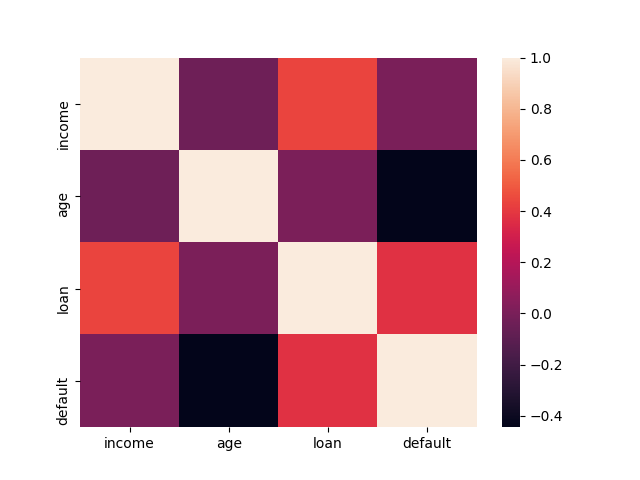

In [59]:
corr = df.drop(labels='clientid', axis=1).corr()
sns.heatmap(corr)
plt.show()

In [11]:
x = df.drop(labels=['clientid', 'default'], axis=1)
y = df['default']
x.shape, y.shape

((2000, 3), (2000,))

## # Model

### ## Self Organize Map

In [12]:
from math import sqrt
from minisom import MiniSom

In [13]:
_xy = 5 * int(sqrt(x.shape[0]))
_xy = int(sqrt(_xy))
_xy

14

In [14]:
som = MiniSom(x=_xy, y=_xy, input_len=x.shape[1])
som.random_weights_init(x.values)
som.train_random(data=x.values, num_iteration=100)

In [15]:
from pylab import pcolor, colorbar, plot

In [16]:
pcolor(som.distance_map().T)
colorbar()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((1500, 3), (1500,), (500, 3), (500,))

In [19]:
model_evaluation = {}

### ## Dense NN

In [20]:
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [21]:
def model():
    clear_session()
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=(x.shape[1])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
    return model

In [22]:
clf = model()
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200, verbose=0)

In [23]:
pred_nn = clf.predict(xtest)
pred_nn = [1 if p > 0.5 else 0 for p in pred_nn]

In [24]:
_ = classification_report(ytest, pred_nn)
print(_)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       422
           1       0.68      0.68      0.68        78

    accuracy                           0.90       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.90      0.90      0.90       500



In [25]:
model_evaluation['dense_nn'] = pred_nn

### ## K-NN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
clf = KNeighborsClassifier()

In [28]:
clf.fit(X=xtrain, y=ytrain)

KNeighborsClassifier()

In [29]:
pred_knn = clf.predict(xtest)

In [30]:
_ = classification_report(ytest, pred_knn)
print(_)

              precision    recall  f1-score   support

           0       0.87      0.95      0.90       422
           1       0.42      0.22      0.29        78

    accuracy                           0.83       500
   macro avg       0.65      0.58      0.60       500
weighted avg       0.80      0.83      0.81       500



In [31]:
model_evaluation['knn'] = pred_knn

### ## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier()

In [34]:
clf.fit(X=xtrain, y=ytrain)

RandomForestClassifier()

In [35]:
pred_rforest = clf.predict(xtest)

In [36]:
_ = classification_report(ytest, pred_rforest)
print(_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       422
           1       1.00      0.90      0.95        78

    accuracy                           0.98       500
   macro avg       0.99      0.95      0.97       500
weighted avg       0.98      0.98      0.98       500



In [37]:
model_evaluation['random_forest'] = pred_rforest

### ## SVM

In [38]:
from sklearn.svm import SVC

In [39]:
model = SVC()

In [40]:
clf.fit(X=xtrain, y=ytrain)

RandomForestClassifier()

In [41]:
pred_svm = clf.predict(xtest)

In [42]:
_ = classification_report(ytest, pred_svm)
print(_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       422
           1       1.00      0.88      0.94        78

    accuracy                           0.98       500
   macro avg       0.99      0.94      0.96       500
weighted avg       0.98      0.98      0.98       500



In [43]:
model_evaluation['svm'] = pred_svm

### ## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
clf = LogisticRegression()

In [46]:
clf.fit(X=xtrain, y=ytrain)

LogisticRegression()

In [47]:
pred_logreg = clf.predict(xtest)

In [48]:
_ = classification_report(ytest, pred_logreg)
print(_)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       422
           1       0.78      0.51      0.62        78

    accuracy                           0.90       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.89      0.90      0.89       500



In [49]:
model_evaluation['logreg'] = pred_logreg

## # Evaluation

In [50]:
model_evaluation.keys()

dict_keys(['dense_nn', 'knn', 'random_forest', 'svm', 'logreg'])

In [62]:
%matplotlib inline

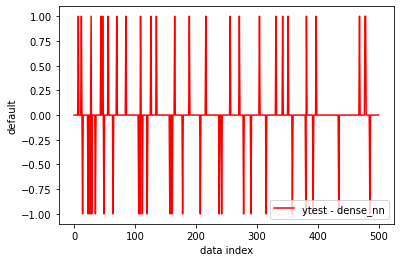

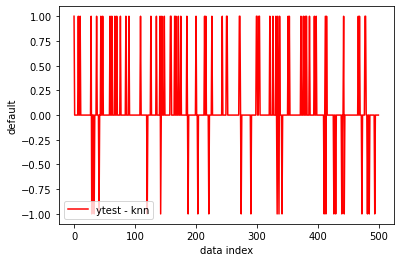

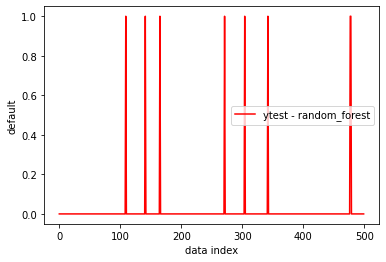

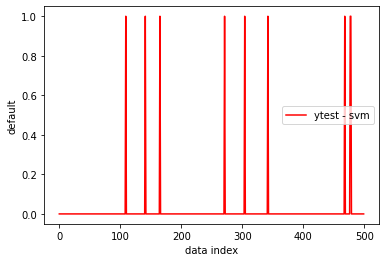

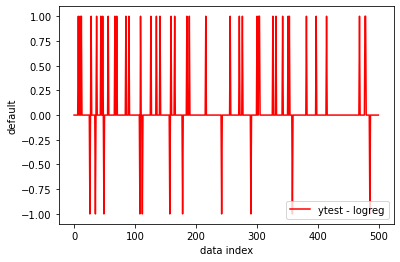

In [67]:
for m in model_evaluation:
#     plt.plot(ytest.values, color='red', label='real value')
#     plt.plot(model_evaluation[m], color='blue', label=m)
    plt.plot(ytest.values - model_evaluation[m], color='red', label=f'ytest - {m}')
    plt.xlabel('data index')
    plt.ylabel('default')
    plt.legend()
    plt.show()